In [1]:

!pip -q install -U ultralytics


import os, random, shutil, yaml
import xml.etree.ElementTree as ET
from glob import glob
from pathlib import Path
from ultralytics import YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.0 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.7 MB/s eta 0:00:00:00:0100:01
Creating new Ultralytic

In [2]:
# Dataset A (Pascal VOC format)
xml_dir = "/kaggle/input/face-mask-detection/annotations"
img_dir = "/kaggle/input/face-mask-detection/images"
datasetA_yolo = "/kaggle/working/yolo_dataset"

# Dataset B (already YOLO-like format but needs fixing)
datasetB_src = "/kaggle/input/face-mask-dataset-yolo-format/dataset"
datasetB_fixed = "/kaggle/working/datasetB_fixed"
datasetB_yolo = "/kaggle/working/datasetB_fixed_yolo"

# Final merged dataset
merged = "/kaggle/working/yolo_merged"

# Train/Val split
train_ratio = 0.8

# Classes
classes = ["with_mask", "without_mask", "mask_incorrect"]


In [3]:
def convert_box(size, box):
    """Convert VOC (xmin, ymin, xmax, ymax) to YOLO normalized format"""
    dw, dh = 1./size[0], 1./size[1]
    x = (box[0] + box[2]) / 2.0
    y = (box[1] + box[3]) / 2.0
    w, h = box[2] - box[0], box[3] - box[1]
    return (x*dw, y*dh, w*dw, h*dh)

# Create dirs
for split in ["train", "val"]:
    os.makedirs(f"{datasetA_yolo}/images/{split}", exist_ok=True)
    os.makedirs(f"{datasetA_yolo}/labels/{split}", exist_ok=True)

# Split XMLs
xml_files = glob(os.path.join(xml_dir, "*.xml"))
random.shuffle(xml_files)
split_index = int(len(xml_files) * train_ratio)
splits = {"train": xml_files[:split_index], "val": xml_files[split_index:]}

def process_files(xml_list, split):
    for xml_file in xml_list:
        tree = ET.parse(xml_file)
        root = tree.getroot()
        w, h = int(root.find("size/width").text), int(root.find("size/height").text)

        labels = []
        for obj in root.iter("object"):
            cls = obj.find("name").text.strip()
            if cls not in classes: continue
            cls_id = classes.index(cls)
            b = (float(obj.find("bndbox/xmin").text), float(obj.find("bndbox/ymin").text),
                 float(obj.find("bndbox/xmax").text), float(obj.find("bndbox/ymax").text))
            bb = convert_box((w,h), b)
            labels.append(f"{cls_id} " + " ".join([f"{a:.6f}" for a in bb]))

        # Save label
        out_label = os.path.join(datasetA_yolo, "labels", split,
                                 os.path.basename(xml_file).replace(".xml", ".txt"))
        with open(out_label, "w") as f: f.write("\n".join(labels))

        # Copy image (.png or .jpg)
        base = os.path.splitext(os.path.basename(xml_file))[0]
        for ext in [".png", ".jpg"]:
            src_img = os.path.join(img_dir, base+ext)
            if os.path.exists(src_img):
                shutil.copy(src_img, os.path.join(datasetA_yolo, "images", split, base+ext))
                break

# Run conversion
for split, files in splits.items():
    process_files(files, split)


In [4]:
# Copy Dataset B from Kaggle input
if os.path.exists(datasetB_fixed): shutil.rmtree(datasetB_fixed)
shutil.copytree(datasetB_src, datasetB_fixed)

# Create YOLO dirs
for split in ["train","val","test"]:
    os.makedirs(os.path.join(datasetB_yolo, "images", split), exist_ok=True)
    os.makedirs(os.path.join(datasetB_yolo, "labels", split), exist_ok=True)

# Move images + labels, rename 'valid' → 'val'
mapping = {"train":"train","valid":"val","test":"test"}
for split, split_name in mapping.items():
    img_dir = os.path.join(datasetB_fixed, "images", split)
    if not os.path.exists(img_dir): continue
    for file in os.listdir(img_dir):
        if file.endswith(".jpg"):
            shutil.copy(os.path.join(img_dir, file),
                        os.path.join(datasetB_yolo, "images", split_name, file))
        elif file.endswith(".txt") and file != "classes.txt":
            shutil.copy(os.path.join(img_dir, file),
                        os.path.join(datasetB_yolo, "labels", split_name, file))

# Fix class IDs (swap 0<->1)
for split in ["train","val","test"]:
    lbl_dir = os.path.join(datasetB_yolo, "labels", split)
    if not os.path.exists(lbl_dir): continue
    for txt_file in os.listdir(lbl_dir):
        path = os.path.join(lbl_dir, txt_file)
        lines = []
        with open(path) as f:
            for line in f:
                parts = line.strip().split()
                if not parts: continue
                cls = int(parts[0])
                new_cls = 0 if cls==1 else 1 if cls==0 else cls
                parts[0] = str(new_cls)
                lines.append(" ".join(parts))
        with open(path, "w") as f: f.write("\n".join(lines))


In [5]:
# Create merged dirs
for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(merged, "images", split), exist_ok=True)
    os.makedirs(os.path.join(merged, "labels", split), exist_ok=True)

def copy_with_prefix(src_dir, dst_dir, prefix, exts):
    if not os.path.exists(src_dir): return
    for file in os.listdir(src_dir):
        if any(file.lower().endswith(ext) for ext in exts):
            shutil.copy(os.path.join(src_dir, file),
                        os.path.join(dst_dir, prefix+"_"+file))

# Merge with prefixes
img_exts, lbl_exts = [".png",".jpg",".jpeg"], [".txt"]
for split in ["train","val","test"]:
    copy_with_prefix(os.path.join(datasetA_yolo, "images", split), os.path.join(merged, "images", split), "A", img_exts)
    copy_with_prefix(os.path.join(datasetA_yolo, "labels", split), os.path.join(merged, "labels", split), "A", lbl_exts)
    copy_with_prefix(os.path.join(datasetB_yolo, "images", split), os.path.join(merged, "images", split), "B", img_exts)
    copy_with_prefix(os.path.join(datasetB_yolo, "labels", split), os.path.join(merged, "labels", split), "B", lbl_exts)


In [6]:
data_yaml = {
    'path': merged,
    'train': 'images/train',
    'val': 'images/val',
    'test': 'images/test',
    'names': {0: 'with_mask', 1: 'without_mask', 2: 'mask_incorrect'}
}
yaml_path = os.path.join(merged, "data.yaml")
with open(yaml_path, 'w') as f: yaml.dump(data_yaml, f)


In [7]:
model = YOLO("yolo11s.pt")  # pre-trained model

model.train(
    data=yaml_path,
    epochs=250,
    patience=20,
    imgsz=640,
    batch=16,
    workers=2,
    device=0
)


Ultralytics 8.3.195 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/yolo_merged/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=250, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=20, perspective=0.0, plots=True, pos

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


      1/250       4.5G      1.603      1.644      1.371        140        640: 100% ━━━━━━━━━━━━ 81/81 2.8it/s 28.6s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 3.2it/s 2.8s0.3ss
                   all        266        960      0.856       0.71      0.777      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      2/250      4.76G      1.282     0.9123      1.167        148        640: 27% ━━━───────── 22/81 3.0it/s 7.7s<19.7s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


      2/250      4.76G       1.33     0.8778      1.174         89        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 27.1s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.8it/s 1.9s0.2s
                   all        266        960      0.722      0.662      0.695      0.395

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      3/250       4.8G      1.327     0.8571      1.171        136        640: 89% ━━━━━━━━━━╸─ 72/81 3.0it/s 24.3s<3.0ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


      3/250       4.8G      1.324     0.8537      1.171         63        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.9s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.9it/s 1.8s0.2s
                   all        266        960      0.821      0.686      0.754      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      4/250      4.84G      1.304     0.8506      1.174        127        640: 79% ━━━━━━━━━─── 64/81 3.0it/s 21.4s<5.6ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


      4/250      4.84G      1.304     0.8504       1.17        109        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.7s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.9it/s 1.8s0.2s
                   all        266        960      0.749      0.704      0.739      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      5/250      4.88G      1.314     0.8268       1.15        150        640: 15% ━╸────────── 12/81 3.0it/s 4.3s<23.0s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


      5/250      4.88G      1.311     0.7893      1.152        104        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.7s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.812      0.706      0.764      0.467

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      6/250      4.92G      1.323     0.8082      1.156        124        640: 35% ━━━━──────── 28/81 3.0it/s 9.6s<17.8s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


      6/250      4.92G      1.314     0.7899      1.157         89        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.9it/s 1.8s0.2s
                   all        266        960      0.804      0.782        0.8      0.495

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      7/250      4.96G      1.263     0.7535      1.128        135        640: 20% ━━────────── 16/81 3.0it/s 5.6s<21.5s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


      7/250      4.96G      1.255     0.7475      1.133        126        640: 98% ━━━━━━━━━━━╸ 79/81 3.0it/s 26.5s<0.7ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


      7/250      4.96G      1.255      0.747      1.132        132        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.7s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.9it/s 1.9s0.2s
                   all        266        960      0.823      0.737      0.798      0.499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      8/250         5G      1.272     0.7566      1.138        127        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.825      0.776      0.824       0.51

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      9/250      5.04G      1.245     0.7188      1.125        113        640: 73% ━━━━━━━━╸─── 59/81 3.0it/s 19.8s<7.3ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


      9/250      5.04G      1.236     0.7137      1.117        172        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.7s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.9it/s 1.8s0.2s
                   all        266        960      0.904      0.751      0.845      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     10/250      5.08G      1.254     0.7389      1.126        161        640: 52% ━━━━━━────── 42/81 3.0it/s 14.3s<12.8s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     10/250      5.08G      1.232     0.7296      1.122        132        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.7s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.806      0.754      0.802      0.506

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     11/250      5.12G      1.231     0.7147      1.121        175        640: 80% ━━━━━━━━━╸── 65/81 3.0it/s 21.8s<5.3ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     11/250      5.12G      1.237      0.722      1.124        104        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.7s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.8it/s 1.9s0.2s
                   all        266        960      0.839      0.778      0.828      0.537

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     12/250      5.16G      1.223     0.6988      1.121         82        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.7s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.879      0.793      0.862      0.552

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     13/250       5.2G      1.222     0.6887      1.102        142        640: 60% ━━━━━━━───── 49/81 3.0it/s 16.5s<10.7s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     13/250       5.2G      1.231     0.6923       1.11        113        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.7s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.839      0.793      0.841      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     14/250      5.24G      1.272     0.7201       1.04        246        640: 5% ╸─────────── 4/81 2.2it/s 1.7s<34.5s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     14/250      5.24G      1.214     0.6765      1.092        126        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.1it/s 1.8s0.2s
                   all        266        960      0.825      0.786      0.842      0.534

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     15/250      5.28G      1.213     0.6776      1.112        140        640: 22% ━━╸───────── 18/81 3.0it/s 6.3s<20.9s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     15/250      5.28G      1.215     0.6802        1.1        100        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.853      0.819      0.864       0.55

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     16/250      5.32G      1.193     0.6776       1.09        177        640: 58% ━━━━━━╸───── 47/81 3.0it/s 15.8s<11.4s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     16/250      5.32G      1.196       0.68      1.087         80        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.7s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.807      0.821      0.836      0.544

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     17/250      5.36G        1.2     0.6769      1.086        181        640: 78% ━━━━━━━━━─── 63/81 3.0it/s 21.1s<5.9ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     17/250      5.36G      1.189     0.6695      1.084         81        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.7s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.1it/s 1.8s0.2s
                   all        266        960      0.853      0.812      0.853      0.552

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     18/250       5.4G      1.141      0.637      1.098        106        640: 11% ━─────────── 9/81 2.9it/s 3.3s<25.1s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     18/250       5.4G      1.165     0.6546      1.081        114        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.7s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.8it/s 1.9s0.2s
                   all        266        960      0.848      0.821      0.859      0.565

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     19/250      5.44G      1.181     0.6583      1.065        191        640: 77% ━━━━━━━━━─── 62/81 3.1it/s 20.8s<6.2ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     19/250      5.44G      1.194     0.6665      1.075        119        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.7s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.874      0.796      0.874       0.57

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     20/250      5.48G      1.183     0.6553      1.084         89        640: 42% ━━━━━─────── 34/81 3.0it/s 11.6s<15.5s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     20/250      5.48G      1.154     0.6428      1.072         77        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.7s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.9it/s 1.8s0.2s
                   all        266        960      0.854      0.802      0.861      0.547

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     21/250      5.52G      1.169     0.6446      1.091        187        640: 91% ━━━━━━━━━━╸─ 74/81 3.0it/s 24.8s<2.3ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     21/250      5.52G      1.171     0.6465      1.088        148        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.7s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960       0.89      0.801      0.877       0.58

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     22/250      5.56G      1.135     0.6151       1.05        143        640: 33% ━━━━──────── 27/81 3.1it/s 9.3s<17.6s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     22/250      5.56G      1.158     0.6404      1.075         88        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.905      0.807       0.87      0.559

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     23/250       5.6G      1.197     0.6704      1.082         86        640: 62% ━━━━━━━───── 50/81 3.1it/s 16.8s<10.1s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     23/250       5.6G      1.156     0.6533      1.069         70        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.7s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.886      0.792      0.867      0.572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     24/250      5.64G      1.147     0.6327      1.067        118        640: 93% ━━━━━━━━━━━─ 75/81 3.0it/s 25.3s<2.0ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     24/250      5.64G      1.143     0.6295      1.067         88        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.9it/s 1.8s0.2s
                   all        266        960      0.889      0.809       0.87      0.566

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     25/250      5.68G      1.151     0.6391      1.058         97        640: 69% ━━━━━━━━──── 56/81 3.1it/s 18.9s<8.2ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     25/250      5.68G       1.16     0.6378      1.058        113        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.9it/s 1.8s0.2s
                   all        266        960      0.902      0.818      0.883      0.585

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     26/250      5.71G      1.133     0.6435      1.045        130        640: 21% ━━╸───────── 17/81 3.0it/s 6.0s<21.3s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     26/250      5.72G      1.131     0.6345      1.058         95        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.7s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.883      0.819      0.874       0.58

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     27/250      5.76G      1.119     0.6202      1.056        211        640: 85% ━━━━━━━━━━── 69/81 3.0it/s 23.2s<4.0ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     27/250      5.76G      1.119      0.621      1.051        100        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.854      0.799      0.871      0.579

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     28/250      5.79G      1.101     0.5979       1.06         97        640: 22% ━━╸───────── 18/81 3.0it/s 6.3s<20.9s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     28/250      5.79G      1.119     0.6066      1.044        101        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.7s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.9it/s 1.8s0.2s
                   all        266        960      0.886      0.837      0.885      0.583

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     29/250      5.84G       1.09     0.5955      1.049        209        640: 75% ━━━━━━━━━─── 61/81 3.0it/s 20.5s<6.7ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     29/250      5.84G        1.1     0.6034       1.05         90        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.861      0.803      0.854      0.555

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     30/250      5.88G      1.103     0.6094      1.031        138        640: 80% ━━━━━━━━━╸── 65/81 3.0it/s 21.9s<5.3ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     30/250      5.88G      1.103     0.6092      1.037         90        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.861      0.834      0.875      0.577

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     31/250      5.91G      1.166     0.6242      1.057        128        640: 9% ━─────────── 7/81 2.7it/s 2.7s<27.3s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     31/250      5.91G      1.115     0.6099      1.045         91        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.902      0.797      0.882      0.597

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     32/250      5.96G      1.094     0.6016      1.045        139        640: 54% ━━━━━━╸───── 44/81 3.0it/s 14.9s<12.3s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     32/250      5.96G      1.108     0.6047       1.04        100        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.887      0.827      0.893      0.589

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     33/250      5.99G       1.11     0.6059      1.058        188        640: 80% ━━━━━━━━━╸── 65/81 3.0it/s 21.9s<5.4ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     33/250      5.99G      1.104     0.6064      1.055         94        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.7s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.812      0.787       0.85      0.555

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     34/250      6.03G      1.086     0.5833      1.019        161        640: 43% ━━━━━─────── 35/81 3.0it/s 11.9s<15.1s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     34/250      6.03G      1.086     0.5846      1.029         66        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.7s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.1it/s 1.8s0.2s
                   all        266        960       0.87      0.832      0.891      0.595

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     35/250      6.07G      1.132     0.6167      1.029        136        640: 14% ━╸────────── 11/81 2.9it/s 4.0s<24.1s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     35/250      6.07G      1.099     0.5905      1.036         68        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.7s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.852      0.867      0.901      0.592

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     36/250      6.11G      1.108      0.596      1.014        196        640: 26% ━━━───────── 21/81 3.0it/s 7.3s<19.7s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     36/250      6.11G      1.101     0.5924      1.033         93        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.838      0.842      0.888      0.595

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     37/250      6.15G      1.059     0.5748      1.027        170        640: 70% ━━━━━━━━──── 57/81 3.0it/s 19.2s<8.1ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     37/250      6.15G      1.079      0.579      1.028        171        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.887       0.81      0.887      0.581

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     38/250      6.44G       1.07     0.5752       1.02        129        640: 56% ━━━━━━╸───── 45/81 3.0it/s 15.3s<12.0s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     38/250      6.79G      1.091     0.5822      1.032        138        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.9s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.8it/s 1.9s0.2s
                   all        266        960      0.922      0.802      0.893      0.596

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     39/250      6.83G      1.107     0.5993      1.041        257        640: 80% ━━━━━━━━━╸── 65/81 3.0it/s 21.8s<5.3ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     39/250      6.83G      1.096     0.5902      1.033        106        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.897      0.825      0.907      0.611

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     40/250      6.88G      1.073     0.5643      1.033        151        640: 88% ━━━━━━━━━━╸─ 71/81 3.0it/s 23.8s<3.3ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     40/250      6.88G      1.073     0.5651      1.034         99        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.7s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.1it/s 1.8s0.2s
                   all        266        960      0.902      0.829      0.904      0.604

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     41/250      6.91G      1.076     0.5845      1.027        116        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.7s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.1it/s 1.8s0.2s
                   all        266        960      0.869      0.863        0.9      0.599

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     42/250      6.95G      1.044      0.553       1.02        169        640: 81% ━━━━━━━━━╸── 66/81 3.0it/s 22.3s<5.0ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     42/250      6.95G      1.053     0.5594      1.026        107        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.9s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.853      0.852      0.899      0.603

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     43/250      6.99G      1.054     0.5686      1.015        158        640: 17% ━━────────── 14/81 3.0it/s 4.9s<22.0s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     43/250      6.99G      1.057     0.5668      1.012        119        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.1it/s 1.8s0.2s
                   all        266        960      0.914      0.824      0.901      0.608

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     44/250      7.03G       1.03     0.5469     0.9916        113        640: 26% ━━━───────── 21/81 3.1it/s 7.3s<19.5s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     44/250      7.03G       1.05     0.5489      1.011        113        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.904      0.837      0.907      0.616

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     45/250      7.07G      1.088     0.5804      1.018        193        640: 77% ━━━━━━━━━─── 62/81 3.0it/s 21.0s<6.3ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     45/250      7.07G      1.086     0.5769      1.018        121        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.9it/s 1.8s0.2s
                   all        266        960       0.85      0.884      0.907      0.612

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     46/250      7.11G      1.071     0.5693      1.025        104        640: 69% ━━━━━━━━──── 56/81 3.0it/s 18.9s<8.3ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     46/250      7.11G      1.067     0.5639      1.021         86        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.7s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.1it/s 1.8s0.2s
                   all        266        960      0.918      0.816      0.899        0.6

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     47/250      7.15G      1.051     0.5618       1.01        237        640: 77% ━━━━━━━━━─── 62/81 3.0it/s 20.8s<6.3ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     47/250      7.15G       1.06     0.5665      1.014        130        640: 96% ━━━━━━━━━━━╸ 78/81 3.1it/s 26.1s<1.0s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     47/250      7.15G       1.06      0.566      1.016         92        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.7s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.885      0.835      0.901      0.607

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     48/250      7.19G      1.066     0.5657      1.019        201        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960       0.86      0.861        0.9      0.599

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     49/250      7.23G      1.067     0.5671      1.022         97        640: 89% ━━━━━━━━━━╸─ 72/81 3.1it/s 24.2s<2.9ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     49/250      7.23G      1.069     0.5689      1.023         71        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.888      0.837      0.905      0.604

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     50/250      7.27G      1.037     0.5467      1.013         79        640: 78% ━━━━━━━━━─── 63/81 3.1it/s 21.2s<5.9ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     50/250      7.27G      1.036     0.5449      1.011        147        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.1it/s 1.8s0.2s
                   all        266        960      0.884        0.8      0.885      0.587

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     51/250      7.31G      1.034     0.5391      1.005        131        640: 33% ━━━━──────── 27/81 3.0it/s 9.3s<18.0s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     51/250      7.31G      1.036       0.54      1.009         99        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.8it/s 1.9s0.2s
                   all        266        960      0.886      0.858      0.916      0.615

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     52/250      7.35G      1.037     0.5414      1.014        117        640: 77% ━━━━━━━━━─── 62/81 3.0it/s 20.8s<6.3ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     52/250      7.35G       1.04      0.542      1.008        137        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.7s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.1it/s 1.8s0.2s
                   all        266        960      0.885      0.852      0.908      0.615

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     53/250      7.39G      1.008     0.5208     0.9922         84        640: 7% ╸─────────── 6/81 2.7it/s 2.3s<28.0s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     53/250      7.39G      1.037      0.545     0.9992         82        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.896      0.859      0.906       0.61

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     54/250      7.43G      1.059     0.5391      1.005        115        640: 32% ━━━╸──────── 26/81 3.0it/s 9.0s<18.4s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     54/250      7.43G      1.047     0.5377      1.002        180        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 27.0s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.9it/s 1.8s0.2s
                   all        266        960      0.909      0.836      0.905      0.612

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     55/250      7.47G      1.036     0.5326      1.003        156        640: 41% ━━━━╸─────── 33/81 3.0it/s 11.3s<15.9s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     55/250      7.47G      1.037     0.5333      1.001        133        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.877      0.864      0.906      0.614

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     56/250      7.51G      1.028     0.5381     0.9944        127        640: 51% ━━━━━━────── 41/81 3.1it/s 13.9s<13.0s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     56/250      7.51G      1.022     0.5318     0.9995         94        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.9it/s 1.8s0.2s
                   all        266        960      0.876      0.849        0.9      0.603

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     57/250      7.55G      1.022     0.5323     0.9902        126        640: 75% ━━━━━━━━━─── 61/81 3.0it/s 20.6s<6.7ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     57/250      7.55G      1.012     0.5289     0.9909         73        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.7s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.8it/s 1.9s0.3s
                   all        266        960      0.881      0.858      0.903      0.615

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     58/250      7.59G      1.043     0.5371      1.004        155        640: 6% ╸─────────── 5/81 2.5it/s 2.0s<30.3s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     58/250      7.59G      1.025     0.5473      1.005        103        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.9s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.868      0.859      0.902      0.605

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     59/250      7.63G      1.005     0.5214     0.9936        155        640: 83% ━━━━━━━━━╸── 67/81 3.0it/s 22.5s<4.7ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     59/250      7.63G      1.012     0.5219     0.9965        117        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.7s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.1it/s 1.8s0.2s
                   all        266        960      0.903      0.849       0.91      0.615

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     60/250      7.67G      1.039     0.5398          1        130        640: 60% ━━━━━━━───── 49/81 3.0it/s 16.6s<10.6s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     60/250      7.67G      1.022     0.5303     0.9989        102        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.902      0.839      0.905      0.615

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     61/250      7.71G      1.007     0.5176     0.9974        134        640: 56% ━━━━━━╸───── 45/81 3.0it/s 15.2s<12.1s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     61/250      7.71G      1.008     0.5166      0.992        166        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.7s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.884      0.869      0.907      0.624

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     62/250      7.75G      1.013     0.5258     0.9862        127        640: 2% ──────────── 2/81 1.6it/s 1.0s<49.6s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     62/250      7.75G     0.9954      0.512     0.9848        117        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.888      0.854      0.907      0.618

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     63/250      7.79G      0.998     0.5159     0.9896        147        640: 93% ━━━━━━━━━━━─ 75/81 3.0it/s 25.2s<2.0ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     63/250      7.79G     0.9979     0.5164     0.9908         73        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.1it/s 1.8s0.2s
                   all        266        960      0.897      0.837        0.9      0.606

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     64/250      7.83G      0.986     0.5019     0.9865        160        640: 31% ━━━╸──────── 25/81 3.1it/s 8.6s<18.2s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     64/250      7.83G     0.9743     0.5022     0.9833         75        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.7s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.897      0.857      0.919      0.623

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     65/250      7.87G      1.014     0.5239     0.9864        149        640: 57% ━━━━━━╸───── 46/81 3.0it/s 15.6s<11.7s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     65/250      7.87G     0.9967     0.5161     0.9846        103        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.1it/s 1.8s0.2s
                   all        266        960      0.903      0.856      0.912      0.613

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     66/250      7.91G     0.9956     0.5131     0.9834        185        640: 46% ━━━━━─────── 37/81 3.0it/s 12.6s<14.5s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     66/250      7.91G     0.9898     0.5082     0.9848         76        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.858      0.854      0.906      0.605

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     67/250      7.95G     0.9705     0.5004     0.9853         87        640: 38% ━━━━╸─────── 31/81 3.0it/s 10.6s<16.6s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     67/250      7.95G     0.9898     0.5063     0.9817         66        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.884      0.867      0.918      0.616

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     68/250      4.73G     0.9651     0.5001     0.9783        154        640: 48% ━━━━━╸────── 39/81 3.1it/s 13.2s<13.7s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     68/250      4.73G     0.9814     0.5026     0.9756        106        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.7s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.8it/s 1.9s0.2s
                   all        266        960      0.889       0.85      0.908       0.61

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     69/250      4.73G     0.9862     0.5015       0.98        136        640: 54% ━━━━━━╸───── 44/81 3.1it/s 14.9s<12.0s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     69/250      4.73G     0.9902     0.5077     0.9869        112        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.9it/s 1.9s0.2s
                   all        266        960       0.89      0.868      0.906      0.611

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     70/250      4.73G     0.9862     0.5111     0.9803        158        640: 84% ━━━━━━━━━━── 68/81 3.0it/s 22.9s<4.3ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     70/250      4.73G      0.981     0.5107     0.9779         87        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.1it/s 1.8s0.2s
                   all        266        960      0.901      0.879      0.912      0.615

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     71/250      4.73G     0.9861      0.504     0.9781        136        640: 33% ━━━━──────── 27/81 3.0it/s 9.3s<18.2s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     71/250      4.73G     0.9685     0.4959     0.9722        146        640: 96% ━━━━━━━━━━━╸ 78/81 3.1it/s 26.2s<1.0ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     71/250      4.73G     0.9663      0.496     0.9723         63        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.1it/s 1.8s0.2s
                   all        266        960      0.913      0.826      0.909      0.615

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     72/250      4.73G     0.9948     0.5073       0.98        135        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.7s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.9it/s 1.8s0.2s
                   all        266        960      0.898      0.846      0.913      0.603

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     73/250      4.73G     0.9882     0.4919     0.9835        143        640: 44% ━━━━━─────── 36/81 3.1it/s 12.2s<14.7s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     73/250      4.73G     0.9946     0.5085     0.9892        115        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.884      0.872      0.915      0.615

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     74/250      4.73G      1.042     0.5079     0.9958        154        640: 0% ──────────── 0/81  0.3s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     74/250      4.73G     0.9901     0.5048      0.975         74        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.891      0.869      0.919      0.612

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     75/250      4.74G     0.9877     0.4958     0.9771        124        640: 93% ━━━━━━━━━━━─ 75/81 3.0it/s 25.2s<2.0ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     75/250      4.74G     0.9848     0.4949      0.976        118        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.914      0.855      0.924      0.625

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     76/250      4.78G     0.9569     0.4867     0.9738        135        640: 53% ━━━━━━────── 43/81 3.0it/s 14.6s<12.6s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     76/250      4.78G     0.9635     0.4906     0.9716        176        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.1it/s 1.8s0.2s
                   all        266        960      0.893      0.872      0.917      0.614

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     77/250      4.82G     0.9844     0.5032     0.9835         96        640: 52% ━━━━━━────── 42/81 3.0it/s 14.3s<12.9s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     77/250      4.82G     0.9832     0.5036     0.9852         82        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.1it/s 1.8s0.2s
                   all        266        960      0.867      0.841      0.898       0.58

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     78/250      4.86G     0.9658     0.4929     0.9598        140        640: 14% ━╸────────── 11/81 3.0it/s 4.0s<23.5s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     78/250      4.86G     0.9607     0.4901     0.9679         84        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.901      0.855      0.912      0.618

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     79/250       4.9G      0.931     0.4749     0.9622        134        640: 32% ━━━╸──────── 26/81 3.1it/s 9.0s<18.0s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     79/250       4.9G     0.9489     0.4856     0.9639        182        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 22% ━━╸───────── 2/9 2.7it/s 0.4s<2.6s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.926      0.848      0.915      0.617

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     80/250      4.94G     0.9612     0.4907     0.9667        107        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.903       0.87      0.925      0.629

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     81/250      4.98G     0.9459     0.4475     0.9541        158        640: 0% ──────────── 0/81  0.3s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     81/250      5.23G     0.9557     0.4855     0.9704        168        640: 96% ━━━━━━━━━━━╸ 78/81 3.0it/s 26.4s<1.0ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     81/250      5.23G     0.9579     0.4861      0.971         74        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 27.0s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.8it/s 1.9s0.2s
                   all        266        960      0.916      0.857      0.931      0.629

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     82/250      5.27G     0.9475     0.4803     0.9619         86        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.9it/s 1.8s0.2s
                   all        266        960      0.899      0.864      0.923       0.63

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     83/250      5.31G     0.9643     0.4935     0.9694        218        640: 43% ━━━━━─────── 35/81 3.0it/s 12.0s<15.5s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     83/250      5.31G     0.9408      0.475     0.9571         93        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.9it/s 1.8s0.2s
                   all        266        960      0.898       0.88      0.924      0.635

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     84/250      5.35G     0.9595     0.4916     0.9794        123        640: 54% ━━━━━━╸───── 44/81 3.1it/s 14.8s<12.1s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     84/250      5.35G     0.9452     0.4839      0.971        143        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.7s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960       0.88       0.89      0.921      0.621

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     85/250      5.39G     0.9742     0.4843     0.9742        196        640: 22% ━━╸───────── 18/81 3.0it/s 6.3s<21.0s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     85/250      5.39G     0.9504     0.4796     0.9621        143        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.9it/s 1.8s0.2s
                   all        266        960      0.913      0.854      0.922      0.625

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     86/250      5.43G     0.9441      0.481     0.9476        147        640: 20% ━━────────── 16/81 3.0it/s 5.6s<21.8s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     86/250      5.43G      0.934     0.4757     0.9592         79        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss


libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.1it/s 1.8s0.2s
                   all        266        960      0.909      0.849      0.916      0.619

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     87/250      5.47G     0.9505     0.4762     0.9696         80        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.911      0.871      0.929      0.628

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     88/250      5.51G      0.902     0.4579      0.946        118        640: 85% ━━━━━━━━━━── 69/81 3.0it/s 23.1s<3.9ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     88/250      5.51G      0.909     0.4624     0.9508         81        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.6s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.1it/s 1.8s0.2s
                   all        266        960      0.917      0.858      0.925      0.631

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     89/250      5.55G      1.002     0.5062     0.9584        100        640: 44% ━━━━━─────── 36/81 3.0it/s 12.2s<14.8s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     89/250      5.55G     0.9677     0.4891     0.9611        145        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.7s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.1it/s 1.8s0.2s
                   all        266        960      0.929      0.859      0.933      0.628

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     90/250      5.59G     0.9567     0.4775     0.9767        116        640: 12% ━─────────── 10/81 3.0it/s 3.6s<24.0s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     90/250      5.59G      0.935     0.4698     0.9712        122        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.9s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.897      0.876      0.928      0.627

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     91/250      5.63G     0.9484     0.4721     0.9658        147        640: 94% ━━━━━━━━━━━─ 76/81 3.0it/s 25.6s<1.7ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     91/250      5.63G     0.9446     0.4709     0.9646        102        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.9s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.9it/s 1.8s0.2s
                   all        266        960      0.881      0.895      0.929      0.637

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     92/250      5.67G     0.9614     0.4724     0.9548        125        640: 62% ━━━━━━━───── 50/81 2.9it/s 17.0s<10.5s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     92/250      5.67G     0.9398     0.4685     0.9505         92        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.9it/s 1.8s0.2s
                   all        266        960      0.914      0.864      0.931      0.643

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     93/250      5.71G     0.9449     0.4757     0.9589         97        640: 57% ━━━━━━╸───── 46/81 3.0it/s 15.6s<11.5s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     93/250      5.71G     0.9314     0.4691     0.9554        143        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.887      0.894      0.935      0.642

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     94/250      5.75G     0.9038     0.4491     0.9492        128        640: 93% ━━━━━━━━━━━─ 75/81 3.1it/s 25.2s<2.0ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     94/250      5.75G     0.9073     0.4507     0.9498         96        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.9s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.9it/s 1.8s0.2s
                   all        266        960      0.914      0.866      0.926      0.641

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     95/250      5.79G     0.8877     0.4551     0.9487        170        640: 59% ━━━━━━━───── 48/81 3.0it/s 16.2s<10.9s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     95/250      5.79G     0.9071     0.4611     0.9506        126        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.9it/s 1.8s0.2s
                   all        266        960      0.897      0.878      0.927      0.627

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     96/250      5.82G     0.9066     0.4651     0.9475        139        640: 22% ━━╸───────── 18/81 3.0it/s 6.3s<21.0s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     96/250      5.83G     0.9114     0.4631     0.9553         79        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.907      0.881      0.922      0.633

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     97/250      5.87G     0.9216     0.4629     0.9554        234        640: 93% ━━━━━━━━━━━─ 75/81 3.0it/s 25.3s<2.0ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     97/250      5.87G     0.9194      0.464     0.9547         85        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960       0.92      0.872      0.933      0.636

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     98/250       5.9G     0.9199     0.4585     0.9555        128        640: 70% ━━━━━━━━──── 57/81 3.0it/s 19.2s<8.0ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     98/250       5.9G     0.9152     0.4564     0.9512        152        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.924      0.871       0.93      0.632

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
     99/250      5.95G     0.9241     0.4605     0.9512        132        640: 51% ━━━━━━────── 41/81 3.1it/s 13.9s<13.1s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


     99/250      5.95G     0.9044     0.4585     0.9496         86        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.9it/s 1.8s0.2s
                   all        266        960        0.9      0.884      0.932      0.643

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    100/250      6.24G     0.9549     0.4707     0.9417        166        640: 33% ━━━━──────── 27/81 3.0it/s 9.3s<17.8s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    100/250      6.24G     0.9153     0.4549     0.9426        119        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.9s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960       0.91      0.863      0.924      0.642

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    101/250      6.28G     0.8921     0.4491     0.9547        112        640: 28% ━━━───────── 23/81 3.0it/s 8.0s<19.1s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    101/250      6.28G     0.8997      0.448     0.9495         69        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.9it/s 1.8s0.2s
                   all        266        960      0.899      0.893      0.931      0.638

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    102/250      6.32G     0.9049     0.4539     0.9564        136        640: 6% ╸─────────── 5/81 2.5it/s 2.0s<30.3s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    102/250      6.32G     0.9002     0.4514     0.9497         93        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.9s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.924       0.88      0.939       0.64

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    103/250      6.36G     0.9074     0.4483      0.946        147        640: 68% ━━━━━━━━──── 55/81 3.0it/s 18.6s<8.7ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    103/250      6.36G     0.9017     0.4459     0.9441        146        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.9s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.907      0.891      0.935      0.636

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    104/250       6.4G     0.9051     0.4559     0.9445        161        640: 70% ━━━━━━━━──── 57/81 3.0it/s 19.2s<7.9ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    104/250       6.4G     0.9028     0.4551     0.9436        119        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.1it/s 1.8s0.2s
                   all        266        960      0.905      0.869      0.939      0.639

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    105/250      6.44G     0.8892     0.4417     0.9438        178        640: 90% ━━━━━━━━━━╸─ 73/81 3.0it/s 24.5s<2.7ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    105/250      6.44G     0.8891     0.4403     0.9442        105        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.905      0.876      0.931       0.64

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    106/250      6.48G     0.8994     0.4475     0.9404        105        640: 77% ━━━━━━━━━─── 62/81 3.0it/s 20.9s<6.3ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    106/250      6.48G     0.8979     0.4463     0.9417        103        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.906      0.875       0.93      0.637

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    107/250      6.52G     0.8783     0.4452     0.9317        140        640: 17% ━━────────── 14/81 3.0it/s 5.0s<22.0s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    107/250      6.52G     0.8728     0.4353     0.9325         94        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.7s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.1it/s 1.8s0.2s
                   all        266        960      0.889      0.884       0.93      0.634

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    108/250      6.56G     0.8717     0.4283     0.9519        138        640: 40% ━━━━╸─────── 32/81 3.0it/s 10.9s<16.2s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    108/250      6.56G     0.8875     0.4393     0.9437        115        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.923      0.869      0.932      0.641

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    109/250       6.6G     0.8796     0.4428     0.9379        112        640: 80% ━━━━━━━━━╸── 65/81 3.0it/s 21.9s<5.4ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    109/250       6.6G     0.8876     0.4453     0.9366        123        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.7s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.9it/s 1.8s0.2s
                   all        266        960       0.93      0.881      0.938      0.646

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    110/250      6.64G     0.8787      0.433     0.9285        122        640: 77% ━━━━━━━━━─── 62/81 3.0it/s 21.0s<6.3ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    110/250      6.64G     0.8837     0.4374      0.931        147        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.9s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.1it/s 1.8s0.2s
                   all        266        960      0.908      0.883      0.928      0.637

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    111/250      6.68G     0.8599     0.4258     0.9363        109        640: 35% ━━━━──────── 28/81 3.0it/s 9.6s<17.5s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    111/250      6.68G     0.8723     0.4371     0.9361        114        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.905      0.882      0.926      0.639

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    112/250      6.71G     0.8952     0.4398     0.9389        116        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.906       0.87      0.927      0.634

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    113/250      6.76G     0.8338     0.3921     0.9361         98        640: 0% ──────────── 0/81  0.3s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    113/250      6.76G     0.8752     0.4359     0.9323        157        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 27.0s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.8it/s 1.9s0.2s
                   all        266        960      0.896      0.882      0.919      0.629

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    114/250      6.79G     0.8831     0.4323     0.9225        202        640: 11% ━─────────── 9/81 2.9it/s 3.3s<25.0s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    114/250      6.79G     0.8491     0.4307     0.9266         83        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 27.0s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.881      0.878      0.915      0.641

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    115/250      6.83G     0.8664     0.4339     0.9376         98        640: 36% ━━━━──────── 29/81 3.0it/s 10.0s<17.1s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    115/250      7.07G     0.8556     0.4287     0.9316        107        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.9s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960        0.9      0.885      0.915       0.63

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    116/250      7.11G     0.8701     0.4313     0.9331        131        640: 94% ━━━━━━━━━━━─ 76/81 3.0it/s 25.5s<1.6ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    116/250      7.11G     0.8683     0.4309     0.9324         62        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.7s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.1it/s 1.8s0.2s
                   all        266        960       0.92       0.87      0.931      0.651

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    117/250      7.15G     0.8564     0.4315     0.9338        101        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.9s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.893      0.884      0.926      0.645

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    118/250      7.19G      0.872     0.4338     0.9374        123        640: 93% ━━━━━━━━━━━─ 75/81 3.0it/s 25.3s<2.0ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    118/250      7.19G     0.8681     0.4315     0.9359         95        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.9s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.1it/s 1.8s0.2s
                   all        266        960       0.91      0.877      0.927       0.64

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    119/250      7.23G      0.854     0.4251     0.9322        124        640: 46% ━━━━━─────── 37/81 3.0it/s 12.7s<14.5s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    119/250      7.23G      0.867     0.4314     0.9331         93        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 27.0s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.902      0.866      0.925      0.634

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    120/250      7.27G      0.843     0.4221       0.93        163        640: 70% ━━━━━━━━──── 57/81 3.0it/s 19.3s<8.0ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    120/250      7.27G     0.8507     0.4254     0.9308        161        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.926      0.861       0.93      0.645

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    121/250      7.31G      0.848     0.4244     0.9259         88        640: 65% ━━━━━━━╸──── 53/81 3.0it/s 18.0s<9.5ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    121/250      7.31G     0.8491     0.4269     0.9288        136        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.9s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.898      0.884      0.921      0.649

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    122/250      7.35G     0.8463     0.4315     0.9338        109        640: 11% ━─────────── 9/81 2.9it/s 3.3s<24.8s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    122/250      7.35G     0.8623      0.428      0.926        112        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.9it/s 1.8s0.2s
                   all        266        960      0.912      0.859      0.924      0.643

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    123/250      7.38G     0.8623     0.4212     0.9243        116        640: 40% ━━━━╸─────── 32/81 3.0it/s 11.0s<16.2s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    123/250      7.38G     0.8427     0.4177     0.9203         55        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.9s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.9it/s 1.8s0.2s
                   all        266        960      0.935      0.852       0.93      0.642

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    124/250      7.43G     0.8738     0.4216     0.9216         87        640: 9% ━─────────── 7/81 2.8it/s 2.6s<26.6s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    124/250      7.43G     0.8553     0.4247     0.9184        169        640: 96% ━━━━━━━━━━━╸ 78/81 3.0it/s 26.2s<1.0ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    124/250      7.43G     0.8534     0.4239      0.919        105        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.904      0.864      0.922      0.635

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    125/250      7.46G      0.855     0.4173     0.9222        162        640: 98% ━━━━━━━━━━━╸ 79/81 3.0it/s 26.6s<0.7ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    125/250      7.46G     0.8558     0.4176     0.9219        127        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.913      0.869      0.928      0.646

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    126/250       7.5G     0.8471     0.4134     0.9205         96        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.876      0.895      0.929      0.635

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    127/250      7.54G     0.9041     0.4527      0.948        131        640: 10% ━─────────── 8/81 2.8it/s 3.0s<25.8s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    127/250      7.54G     0.8412     0.4204     0.9191         98        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.9s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.1it/s 1.8s0.2s
                   all        266        960      0.881      0.891      0.918      0.635

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    128/250      7.58G     0.8393     0.4184     0.9233        144        640: 90% ━━━━━━━━━━╸─ 73/81 3.1it/s 24.6s<2.6ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    128/250      7.58G     0.8371     0.4177     0.9226        132        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.924      0.883      0.937      0.644

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    129/250      7.62G     0.8255      0.414     0.9176         67        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.1it/s 1.8s0.2s
                   all        266        960      0.911      0.881      0.933      0.656

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    130/250      7.66G     0.8328      0.417     0.9323        135        640: 47% ━━━━━╸────── 38/81 3.0it/s 12.9s<14.3s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    130/250      7.66G     0.8378     0.4159     0.9276        114        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.9it/s 1.8s0.2s
                   all        266        960      0.915      0.883      0.933      0.642

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    131/250       7.7G     0.8347      0.414     0.9223        142        640: 88% ━━━━━━━━━━╸─ 71/81 3.0it/s 23.9s<3.4ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    131/250       7.7G     0.8309     0.4119     0.9198         86        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.1it/s 1.8s0.2s
                   all        266        960      0.897      0.893      0.929      0.652

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    132/250      7.97G      0.816     0.4107     0.9213        154        640: 67% ━━━━━━━━──── 54/81 3.0it/s 18.3s<9.0ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    132/250      7.97G       0.83     0.4124     0.9196        124        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.914      0.853      0.915      0.642

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    133/250      4.76G     0.7878     0.3961     0.9143        170        640: 56% ━━━━━━╸───── 45/81 3.0it/s 15.2s<12.0s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    133/250      4.76G     0.8212     0.4107     0.9184        126        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.7s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.1it/s 1.8s0.2s
                   all        266        960      0.923      0.865      0.928      0.636

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    134/250      4.76G     0.8193       0.41     0.9141        147        640: 36% ━━━━──────── 29/81 3.0it/s 10.0s<17.4s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    134/250      4.76G     0.8274     0.4078     0.9106        115        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 27.4s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.908      0.877       0.93      0.649

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    135/250      4.76G     0.7956     0.4015     0.9061        108        640: 17% ━━────────── 14/81 3.0it/s 5.0s<22.0s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    135/250      4.76G      0.839     0.4117     0.9158        170        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.7s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.896       0.88      0.929      0.651

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    136/250      4.76G     0.8329     0.4092     0.9169        124        640: 27% ━━━───────── 22/81 3.0it/s 7.6s<19.6s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    136/250      4.76G     0.8283     0.4084      0.911         91        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.9it/s 1.8s0.2s
                   all        266        960       0.92      0.862      0.927      0.644

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    137/250      4.76G     0.8131     0.3991     0.9059        214        640: 69% ━━━━━━━━──── 56/81 3.0it/s 18.8s<8.2ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    137/250      4.76G     0.8186      0.403     0.9091         70        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.7s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.9it/s 1.8s0.2s
                   all        266        960      0.916      0.876      0.933      0.654

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    138/250      4.76G     0.8072      0.399     0.9115        103        640: 78% ━━━━━━━━━─── 63/81 3.0it/s 21.3s<5.9ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    138/250      4.76G     0.8084     0.3988     0.9139         85        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.9s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.9it/s 1.8s0.2s
                   all        266        960      0.933      0.854      0.927      0.644

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    139/250      4.76G     0.8026     0.3971     0.9034        101        640: 44% ━━━━━─────── 36/81 3.0it/s 12.3s<14.9s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    139/250      4.76G     0.8183     0.4036     0.9089         82        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.9s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.1it/s 1.8s0.2s
                   all        266        960      0.908      0.868      0.923      0.639

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    140/250      4.76G     0.8294     0.4076     0.9084        158        640: 36% ━━━━──────── 29/81 3.0it/s 9.9s<17.3s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    140/250      4.76G     0.8243     0.4076     0.9108         55        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.897       0.87      0.928       0.64

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    141/250      5.11G     0.8316     0.4103     0.9028        151        640: 63% ━━━━━━━╸──── 51/81 3.1it/s 17.2s<9.8ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    141/250      5.11G      0.821     0.4045     0.9059        143        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.1it/s 1.8s0.2s
                   all        266        960      0.912      0.879      0.931      0.652

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    142/250      5.15G     0.8034     0.3981     0.9082        123        640: 85% ━━━━━━━━━━── 69/81 3.0it/s 23.3s<4.0ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    142/250      5.15G     0.8012     0.3981     0.9084         78        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.9s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.866      0.906      0.923      0.646

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    143/250      5.19G     0.8078     0.3964     0.9142        126        640: 25% ━━╸───────── 20/81 3.0it/s 6.9s<20.2s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    143/250      5.19G     0.8044     0.3963     0.9067        110        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.1it/s 1.8s0.2s
                   all        266        960      0.878      0.892      0.922      0.644

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    144/250      5.23G     0.7985     0.3967     0.9059        158        640: 74% ━━━━━━━━╸─── 60/81 3.0it/s 20.2s<7.0ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    144/250      5.23G     0.8007     0.3981     0.9053        103        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.7s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.1it/s 1.8s0.2s
                   all        266        960      0.891      0.895      0.935      0.657

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    145/250      5.27G     0.7984      0.396     0.9234        144        640: 23% ━━╸───────── 19/81 3.0it/s 6.7s<20.7s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    145/250      5.27G     0.8122     0.4009     0.9129         76        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.904      0.888      0.935      0.655

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    146/250      5.31G     0.7644     0.3771     0.9114        107        640: 14% ━╸────────── 11/81 3.0it/s 4.0s<23.2s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    146/250      5.31G     0.8041     0.3973     0.9124         74        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.9it/s 1.8s0.2s
                   all        266        960      0.889      0.893      0.929      0.653

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    147/250      5.35G     0.7925     0.3926      0.906        169        640: 80% ━━━━━━━━━╸── 65/81 3.0it/s 21.9s<5.3ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    147/250      5.35G     0.8002     0.3953      0.907        171        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.1it/s 1.8s0.2s
                   all        266        960      0.905      0.895      0.928      0.655

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    148/250      5.39G     0.7993     0.3954     0.9077        132        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.1it/s 1.8s0.2s
                   all        266        960      0.922      0.881      0.939      0.658

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    149/250      5.43G     0.8078     0.3985     0.9132        137        640: 52% ━━━━━━────── 42/81 3.0it/s 14.3s<13.0s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    149/250      5.43G     0.8018     0.3919     0.9077         89        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.915       0.88      0.932      0.656

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    150/250      5.47G     0.8048     0.4019     0.9061        126        640: 77% ━━━━━━━━━─── 62/81 3.1it/s 20.9s<6.2ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    150/250      5.47G      0.805     0.3996     0.9037         97        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.908      0.884      0.937      0.655

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    151/250      5.51G     0.7814     0.3849     0.9052        166        640: 26% ━━━───────── 21/81 3.0it/s 7.3s<19.7s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    151/250      5.51G     0.7737     0.3853     0.8978        219        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.7s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.1it/s 1.8s0.2s
                   all        266        960       0.89      0.911      0.939      0.653

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    152/250      5.55G     0.8005     0.3928     0.9293        141        640: 5% ╸─────────── 4/81 2.3it/s 1.6s<33.1s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    152/250      5.55G     0.7893     0.3882     0.8993        105        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.9s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.2it/s 1.7s0.2s
                   all        266        960      0.898       0.89      0.929      0.648

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    153/250      5.59G     0.7957     0.3955     0.9083        125        640: 74% ━━━━━━━━╸─── 60/81 3.1it/s 20.3s<6.8ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    153/250      5.59G     0.7877     0.3915     0.9094         86        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.1it/s 1.8s0.2s
                   all        266        960      0.918       0.88      0.933      0.661

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    154/250      5.63G     0.7858     0.3899     0.8977        191        640: 23% ━━╸───────── 19/81 3.0it/s 6.6s<20.5s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    154/250      5.63G     0.7848     0.3894      0.897         79        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.9s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.928      0.866      0.937      0.667

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    155/250      5.67G     0.7754     0.3845     0.9022        168        640: 60% ━━━━━━━───── 49/81 3.1it/s 16.5s<10.5s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    155/250      5.67G     0.7873     0.3899     0.9024        125        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.1it/s 1.8s0.2s
                   all        266        960      0.939      0.862      0.928      0.654

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    156/250      5.71G     0.7829     0.3866     0.8934        155        640: 49% ━━━━━╸────── 40/81 3.0it/s 13.6s<13.5s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    156/250      5.71G     0.7851     0.3864     0.9005        109        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.7s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.1it/s 1.8s0.2s
                   all        266        960      0.899      0.888      0.931      0.664

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    157/250      5.75G     0.7682     0.3763     0.9015        108        640: 73% ━━━━━━━━╸─── 59/81 3.1it/s 19.8s<7.2ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    157/250      5.75G     0.7689      0.378     0.9025         67        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.7s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.1it/s 1.8s0.2s
                   all        266        960      0.903      0.892      0.919      0.657

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    158/250      5.79G     0.7558       0.37     0.9117        135        640: 7% ╸─────────── 6/81 2.7it/s 2.3s<27.7s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    158/250      5.79G     0.7773     0.3841     0.8961        132        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.9s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.1it/s 1.8s0.2s
                   all        266        960      0.914      0.874      0.925      0.664

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    159/250      5.83G     0.8264     0.4051     0.8912        172        640: 14% ━╸────────── 11/81 2.9it/s 4.0s<24.2s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    159/250      5.83G     0.7795      0.388     0.8952         78        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.909      0.886      0.929       0.66

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    160/250      5.87G      0.767     0.3819     0.8924        160        640: 62% ━━━━━━━───── 50/81 2.9it/s 16.9s<10.5s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    160/250      5.87G     0.7752     0.3842     0.8935        106        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.1it/s 1.8s0.2s
                   all        266        960      0.908      0.884      0.939      0.662

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    161/250       5.9G     0.7757     0.3869     0.9025        159        640: 2% ──────────── 2/81 1.5it/s 1.0s<51.5s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    161/250      5.91G     0.7761     0.3856     0.8956         92        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.916      0.865      0.933      0.662

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    162/250      5.95G     0.7523      0.374     0.8971        135        640: 4% ──────────── 3/81 2.1it/s 1.3s<38.0s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    162/250      5.95G     0.7604     0.3774     0.8934         88        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.898      0.898       0.93      0.662

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    163/250      5.98G     0.7732     0.3835     0.8904        106        640: 68% ━━━━━━━━──── 55/81 3.0it/s 18.6s<8.8ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    163/250      5.98G     0.7648     0.3806     0.8946        142        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.918      0.867      0.937      0.653

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    164/250      6.02G     0.7293     0.3734     0.9023        121        640: 21% ━━╸───────── 17/81 3.0it/s 5.9s<21.1s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    164/250      6.36G     0.7639     0.3831     0.8951        148        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.1it/s 1.8s0.2s
                   all        266        960      0.887      0.897      0.933      0.656

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    165/250       6.4G     0.7747     0.3683     0.8957        113        640: 1% ──────────── 1/81 0.8it/s 0.7s<1:36

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    165/250       6.4G     0.7701     0.3738     0.8975         59        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.1it/s 1.7s0.2s
                   all        266        960      0.905      0.896      0.933      0.662

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    166/250      6.44G     0.7724     0.3813     0.8915        151        640: 69% ━━━━━━━━──── 56/81 3.0it/s 18.9s<8.4ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    166/250      6.44G     0.7766     0.3843     0.8931        137        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.915      0.882      0.936      0.663

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    167/250      6.48G     0.7522      0.377     0.8997        119        640: 15% ━╸────────── 12/81 3.0it/s 4.3s<23.1s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    167/250      6.48G     0.7617     0.3772     0.8967         72        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.1it/s 1.8s0.2s
                   all        266        960      0.898      0.895      0.933      0.659

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    168/250      6.52G     0.7399     0.3672     0.8986        157        640: 36% ━━━━──────── 29/81 3.0it/s 9.9s<17.3s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    168/250      6.52G     0.7539     0.3758     0.8953        115        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.883       0.91      0.927      0.651

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    169/250      6.56G     0.7576     0.3746     0.8883        161        640: 80% ━━━━━━━━━╸── 65/81 3.0it/s 21.9s<5.3ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    169/250      6.56G     0.7551      0.373     0.8887        133        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.901      0.899      0.932      0.655

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    170/250       6.6G     0.7564     0.3688     0.8849        157        640: 9% ━─────────── 7/81 2.8it/s 2.6s<26.3s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    170/250       6.6G     0.7448     0.3712     0.8908        151        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.892      0.897       0.93      0.661

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    171/250      6.64G     0.7518     0.3731     0.8888        129        640: 75% ━━━━━━━━━─── 61/81 3.1it/s 20.6s<6.5ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    171/250      6.64G     0.7539     0.3736     0.8884        153        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.9it/s 1.8s0.2s
                   all        266        960      0.894      0.891      0.929      0.658

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    172/250      6.68G     0.7614     0.3777     0.8993        122        640: 31% ━━━╸──────── 25/81 3.1it/s 8.6s<18.3s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    172/250      6.68G     0.7651     0.3812     0.8947        123        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.9s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.881      0.893       0.93       0.66

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    173/250      6.72G     0.7181     0.3719      0.889        160        640: 7% ╸─────────── 6/81 2.6it/s 2.3s<28.4s

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    173/250      6.72G     0.7442     0.3666     0.8924        138        640: 95% ━━━━━━━━━━━─ 77/81 3.0it/s 25.9s<1.3ss

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


    173/250      6.72G     0.7438     0.3672     0.8929         72        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.8s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s0.2s
                   all        266        960      0.912      0.885      0.934      0.665

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
    174/250      6.76G     0.7481     0.3679     0.8895        120        640: 100% ━━━━━━━━━━━━ 81/81 3.0it/s 26.9s0.3ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.9it/s 1.9s0.2s
                   all        266        960      0.896      0.889      0.928      0.666
EarlyStopping: Training stopped early as no improvement observed in last 20 epochs. Best results observed at epoch 154, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `p

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        266        960      0.927      0.866      0.937      0.667
             with_mask        243        787      0.952      0.934      0.972      0.726
          without_mask         86        173      0.902      0.798      0.902      0.608
Speed: 0.1ms preprocess, 3.8ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to /kaggle/working/runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e1042d1f5d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [8]:
run_dir = "/kaggle/working/runs/detect/train/weights"
shutil.copy(f"{run_dir}/best.pt", "/kaggle/working/best.pt")
shutil.copy(f"{run_dir}/last.pt", "/kaggle/working/last.pt")


'/kaggle/working/last.pt'

In [9]:
# Evaluate the trained model on validation set
results = model.val()

# Print summary of metrics
print(results.results_dict)  
# Contains: mAP@50, mAP@50-95, precision, recall, etc.


Ultralytics 8.3.195 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11s summary (fused): 100 layers, 9,413,961 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2695.4±1278.1 MB/s, size: 468.3 KB)
val: Scanning /kaggle/working/yolo_merged/labels/val.cache... 266 images, 2 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 266/266 466.0Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 4.8it/s 3.6s0.1s


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        266        960      0.925      0.868      0.937      0.666
             with_mask        243        787      0.952      0.938      0.971      0.725
          without_mask         86        173      0.898      0.798      0.903      0.607
Speed: 0.7ms preprocess, 7.0ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to /kaggle/working/runs/detect/train2
{'metrics/precision(B)': 0.924921036420634, 'metrics/recall(B)': 0.8677130538886971, 'metrics/mAP50(B)': 0.9369947585773017, 'metrics/mAP50-95(B)': 0.6659708491758283, 'fitness': 0.6930732401159757}


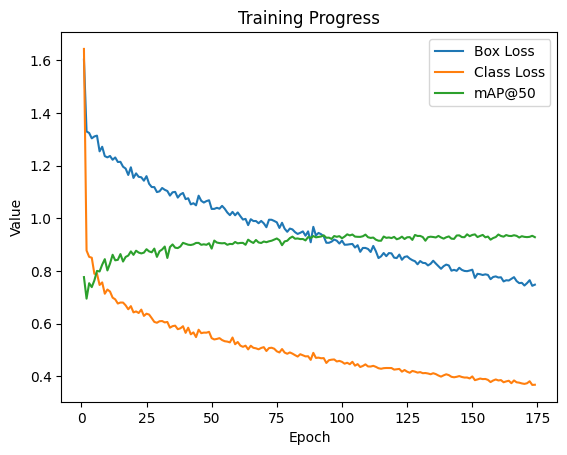

In [10]:
import matplotlib.pyplot as plt

# Loss curves are stored in results.csv (inside run folder)
import pandas as pd

df = pd.read_csv("runs/detect/train/results.csv")
plt.plot(df["epoch"], df["train/box_loss"], label="Box Loss")
plt.plot(df["epoch"], df["train/cls_loss"], label="Class Loss")
plt.plot(df["epoch"], df["metrics/mAP50(B)"], label="mAP@50")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Training Progress")
plt.legend()
plt.show()


In [14]:
import os

base = "/kaggle/working/runs/detect"
print("Available runs:", os.listdir(base))


Available runs: ['train', 'train2']


⚠️ results.png not found in /kaggle/working/runs/detect/train2/


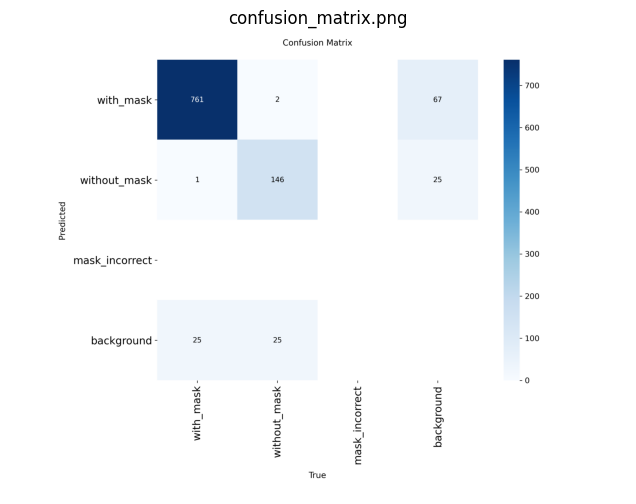

⚠️ PR_curve.png not found in /kaggle/working/runs/detect/train2/
⚠️ F1_curve.png not found in /kaggle/working/runs/detect/train2/


In [15]:
import matplotlib.pyplot as plt
import cv2

results_dir = "/kaggle/working/runs/detect/train2/"
plots = ["results.png", "confusion_matrix.png", "PR_curve.png", "F1_curve.png"]

for plot in plots:
    img_path = os.path.join(results_dir, plot)
    if os.path.exists(img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(8,6))
        plt.imshow(img)
        plt.axis("off")
        plt.title(plot)
        plt.show()
    else:
        print(f"⚠️ {plot} not found in {results_dir}")


In [13]:
# Finally, save the trained model weights
model.save("best_model.pt")


In [24]:
from ultralytics import YOLO

# Load your trained weights
model = YOLO("runs/detect/train/weights/best.pt")

# Run prediction
results = model.predict(
    source="/kaggle/input/test-image-for-model/106467352-1585602933667virus-medical-flu-mask-health-protection-woman-young-outdoor-sick-pollution-protective-danger-face_t20_o07dbe.jpg",
    save=True,
    conf=0.25
)



image 1/1 /kaggle/input/test-image-for-model/106467352-1585602933667virus-medical-flu-mask-health-protection-woman-young-outdoor-sick-pollution-protective-danger-face_t20_o07dbe.jpg: 448x640 1 with_mask, 10.0ms
Speed: 2.5ms preprocess, 10.0ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)
Results saved to /kaggle/working/runs/detect/predict2


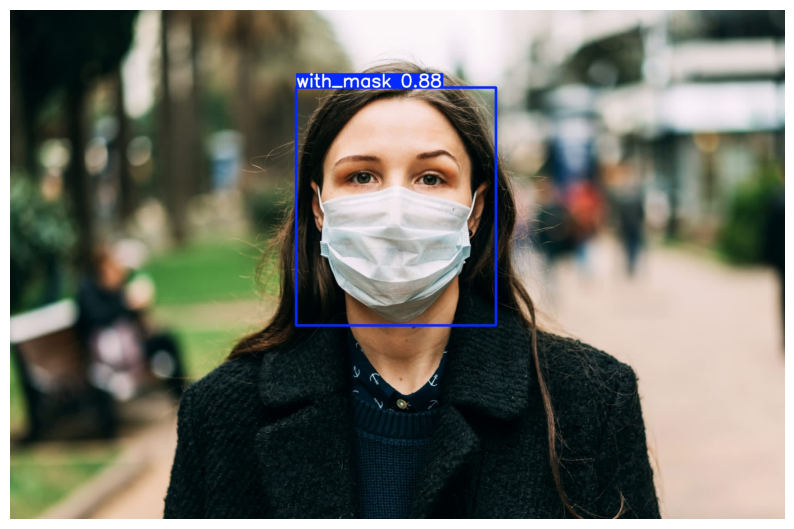

In [25]:
import matplotlib.pyplot as plt
import cv2
import os

# Access the first result
res = results[0]

# Get the folder where prediction was saved
pred_dir = res.save_dir

# Get the predicted image path
pred_img_path = os.path.join(pred_dir, os.path.basename(res.path))

# Read and display
img = cv2.imread(pred_img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")
plt.show()


NameError: name 'runs' is not defined